In [1]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [3]:
import pulse_compiler_helper_fns

In [4]:
q.IBMQ.load_account() # Load account from disk

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
provider = q.IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
backend = provider.get_backend('alt_almaden')
system = q.pulse.PulseChannelSpec.from_backend(backend)
config = backend.configuration()
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


In [73]:
thetas = np.linspace(0, np.pi/2, 21, endpoint=True)
print(thetas)
print(thetas * 180 / np.pi)

[0.         0.07853982 0.15707963 0.23561945 0.31415927 0.39269908
 0.4712389  0.54977871 0.62831853 0.70685835 0.78539816 0.86393798
 0.9424778  1.02101761 1.09955743 1.17809725 1.25663706 1.33517688
 1.41371669 1.49225651 1.57079633]
[ 0.   4.5  9.  13.5 18.  22.5 27.  31.5 36.  40.5 45.  49.5 54.  58.5
 63.  67.5 72.  76.5 81.  85.5 90. ]


In [8]:
circuits = []
schedules = []

In [9]:
## Standard Way: Cnot RZ Cnot
for theta in thetas:
    circuit = q.QuantumCircuit(2)
    circuit.h(0)
    circuit.h(1)
    circuit.cx(0, 1)
    circuit.rz(theta, 1)
    circuit.cx(0, 1)
    circuit.h(0)
    circuit.h(1)

    decomposed_circuit = circuit.decompose()

    pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
    transpiled_circuit = q.transpile(decomposed_circuit, backend, optimization_level=1)

    schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
    schedule |= measure << schedule.duration
    schedules.append(schedule)
    
    circuits.append(circuit)

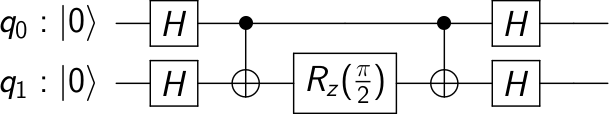

In [10]:
circuit.draw(output='latex')

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/providers/models/backendconfiguration.py:399: UserWarning: The control channel appropriate for an interaction should be determined from the hamiltonian. This will be determined for you in the future.
  warnings.warn("The control channel appropriate for an interaction should be determined "


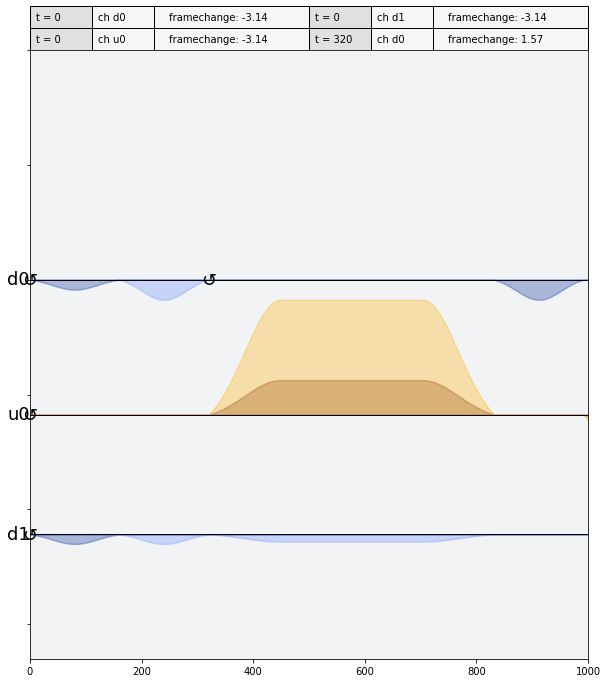

In [47]:
schedules[20].draw(channels=[config.drive(0), config.drive(1), config.control(0)], plot_range=(0,1000))

In [12]:
## Optimized Way Way: zz_interaction decomposes directly to cross resonancefor theta in thetas:
for theta in thetas:
    circuit = q.QuantumCircuit(2)
    circuit.h(0)
    circuit.h(1)
    circuit.zz_interaction(theta, 0, 1)
    circuit.h(0)
    circuit.h(1)

    decomposed_circuit = circuit.decompose()

    pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
    transpiled_circuit = q.transpile(decomposed_circuit, backend, optimization_level=1)

    schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
    schedule |= measure << schedule.duration
    schedules.append(schedule)

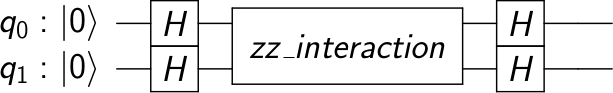

In [13]:
circuit.draw(output='latex')

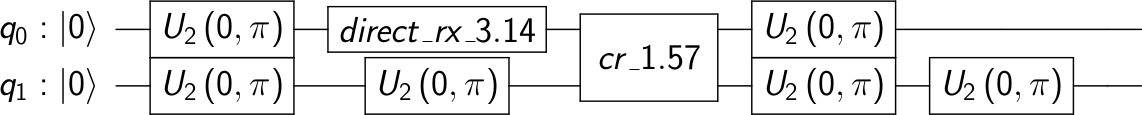

In [14]:
circuit.decompose().draw(output='latex')

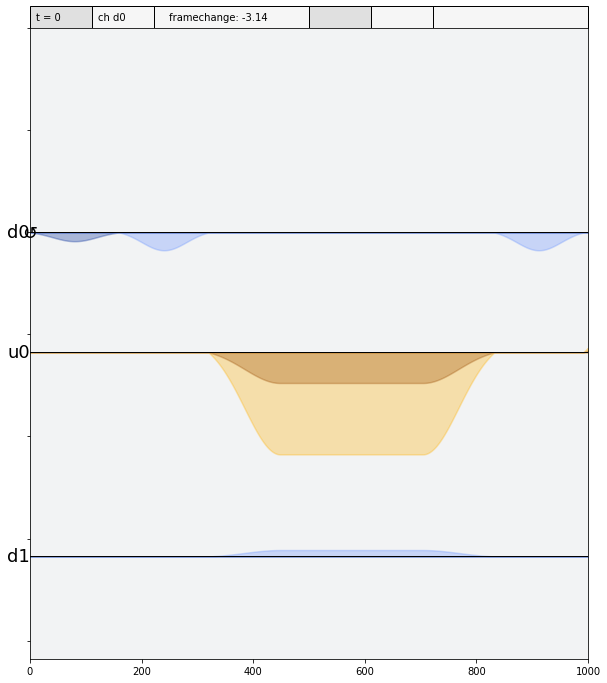

In [46]:
schedules[41].draw(channels=[config.drive(0), config.drive(1), config.control(0)], plot_range=(0,1000))

In [16]:
shots = 1000
job = q.execute(schedules, backend=backend, shots=shots)
print('job is %s' % job.job_id())

job is 5dd804f6c02fc60018634d12


/anaconda3/lib/python3.6/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


In [22]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

# Run a mitigation cal job

In [18]:
import qiskit.ignis.mitigation.measurement as mit
meas_qcs, meas_labels = mit.complete_meas_cal(qubit_list=[0,1])
meas_qcs_transpiled = q.transpile(meas_qcs, backend, basis_gates=['x'])
meas_schedules = q.schedule(meas_qcs_transpiled, backend=backend, cmd_def=cmd_def)
job_mit = q.execute(meas_schedules, backend)

In [52]:
job_mit.status()

<JobStatus.DONE: 'job has successfully run'>

-----
## Analysis

In [53]:
from qiskit.result import marginal_counts

In [54]:
result = job.result()

In [55]:
# mitigate results
result_mit = marginal_counts(job_mit.result(), [0,1])
readout_fitter = mit.CompleteMeasFitter(result_mit, meas_labels)
readout_fitter.cal_matrix

array([[0.95019531, 0.06542969, 0.08300781, 0.00878906],
       [0.02441406, 0.91308594, 0.00390625, 0.10253906],
       [0.02441406, 0.00292969, 0.88867188, 0.08984375],
       [0.00097656, 0.01855469, 0.02441406, 0.79882812]])

In [56]:
standard_counts_list = []
for i in range(len(thetas)):
    counts = marginal_counts(result.get_counts(i), [0,1])
    counts = readout_fitter.filter.apply(counts)
    standard_counts_list.append(counts)
print(standard_counts_list)

[{'00': 977.7824794442139, '01': 20.297636051051253, '10': 1.554555095761856e-13, '11': 1.9198845047345798}, {'00': 981.0333034941192, '01': 10.177566046673338, '11': 8.789130459207994}, {'00': 986.3074997216905, '01': 13.692500278307385, '10': 3.036237927744878e-12}, {'00': 967.4032918290145, '01': 13.354289763807492, '10': 2.568480584469457e-12, '11': 19.2424184071754}, {'00': 958.4512528431084, '01': 11.355553242136091, '10': 5.273884627621239e-15, '11': 30.193193914755465}, {'00': 942.9796927766614, '01': 22.403834389214563, '10': 7.93245026955991e-13, '11': 34.61647283412324}, {'00': 936.4991548559925, '01': 18.844055204719325, '10': 1.1607923823542254e-13, '11': 44.656789939288075}, {'00': 911.0712857301675, '01': 12.501196437441923, '10': 2.0434738970398492e-13, '11': 76.42751783239048}, {'00': 887.0050048623744, '01': 7.943802701069243, '11': 105.05119243655668}, {'00': 879.2914844685259, '01': 3.7806999109866712, '10': 2.387326447639282e-14, '11': 116.92781562048731}, {'00': 8

In [57]:
optimized_counts_list = []
for i in range(len(thetas), len(thetas) * 2):
    counts = marginal_counts(result.get_counts(i), [0,1])
    counts = readout_fitter.filter.apply(counts)
    optimized_counts_list.append(counts)
print(optimized_counts_list)

[{'00': 984.112486199999, '01': 15.637808644230777, '10': 1.8001203826167878e-13, '11': 0.24970515576999147}, {'00': 988.9702194586682, '01': 7.455438042193103, '10': 9.471590178833367e-15, '11': 3.5743424991386785}, {'00': 983.0613624998647, '10': 2.1518342663284784e-12, '11': 16.938637500133648}, {'00': 959.1258779110428, '01': 1.9081958235744878e-17, '10': 2.264628429413988, '11': 38.60949365954311}, {'00': 968.433918776013, '01': 3.086420008457935e-14, '11': 31.566081223987503}, {'00': 941.0210775356924, '01': 2.7533531010703882e-14, '10': 9.597878047884478e-13, '11': 58.97892246430673}, {'00': 919.8859664702342, '01': 1.4210854715202004e-14, '10': 4.440892098500626e-15, '11': 80.1140335297658}, {'00': 900.1557458322856, '01': 6.6760162632103, '11': 93.16823790450415}, {'00': 854.6858414236458, '01': 10.701665951960885, '11': 134.61249262439668}, {'00': 841.134851471409, '01': 3.7536564644200676, '11': 155.11149206417093}, {'00': 851.7829060908867, '01': 2.3897536900024527, '11': 1

In [58]:
# infer output state vectors, up to phase of each element (phase won't matter for overlap calculation)
standard_state_vectors = []
for counts in standard_counts_list:
        standard_state_vectors.append(np.array([
            np.sqrt(counts.get('00', 0)/shots),
            np.sqrt(counts.get('01', 0)/shots),
            np.sqrt(counts.get('10', 0)/shots),
            np.sqrt(counts.get('11', 0)/shots)]))

In [59]:
optimized_state_vectors = []
for counts in optimized_counts_list:
        optimized_state_vectors.append(np.array([
            np.sqrt(counts.get('00', 0)/shots),
            np.sqrt(counts.get('01', 0)/shots),
            np.sqrt(counts.get('10', 0)/shots),
            np.sqrt(counts.get('11', 0)/shots)]))

### plot fidelities

In [70]:
from qiskit.quantum_info.states import Statevector
ideal_state_vectors = []
for c in circuits:
    ideal = Statevector.from_instruction(c).data
    ideal_state_vectors.append(ideal)

In [71]:
from qiskit.quantum_info import state_fidelity

standard_fidelities = []
for sv1, sv2 in zip(standard_state_vectors, ideal_state_vectors):
    fidelity = state_fidelity(np.abs(sv1), np.abs(sv2))
    standard_fidelities.append(fidelity)

optimized_fidelities = []
for sv1, sv2 in zip(optimized_state_vectors, ideal_state_vectors):
    fidelity = state_fidelity(np.abs(sv1), np.abs(sv2))
    optimized_fidelities.append(fidelity)

cross_fidelities = []
for sv1, sv2 in zip(standard_state_vectors, optimized_state_vectors):
    fidelity = state_fidelity(np.abs(sv1), np.abs(sv2))
    cross_fidelities.append(fidelity)

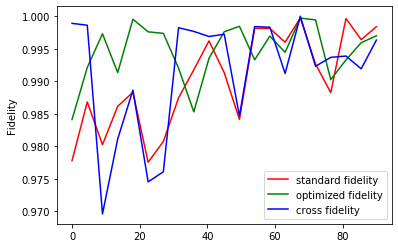

In [72]:
plt.plot(thetas * 180 / np.pi, standard_fidelities, 'r')
plt.plot(thetas * 180 / np.pi, optimized_fidelities, 'g')
plt.plot(thetas * 180 / np.pi, cross_fidelities, 'b')
plt.ylabel('Fidelity')
plt.legend(['standard fidelity', 'optimized fidelity', 'cross fidelity'])

### plot |11>

In [33]:
# infer output state vectors, up to phase of each element (phase won't matter for overlap calculation)
standard_00s = []
standard_11s = []
for counts in standard_counts_list:
    standard_00s.append(counts.get('00', 0))
    standard_11s.append(counts.get('11', 0))
        
optimized_00s = []
optimized_11s = []
for counts in optimized_counts_list:
    optimized_00s.append(counts.get('00', 0))
    optimized_11s.append(counts.get('11', 0))
        
ideal_00s = []
ideal_11s = []
for ideal in ideal_state_vectors:
    ideal_11s.append(1000 * np.abs(ideal[3]) ** 2)
    ideal_00s.append(1000 * np.abs(ideal[0]) ** 2)

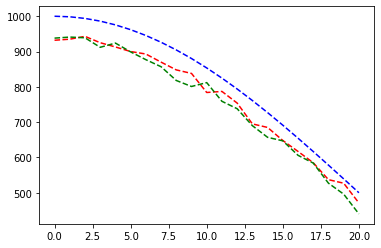

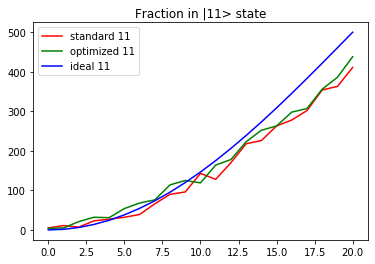

In [34]:
plt.plot(standard_00s, 'r--', label='standard 00')
plt.plot(optimized_00s, 'g--', label='optimized 00')
plt.plot(ideal_00s, 'b--', label='ideal 00')
plt.figure()
plt.plot(standard_11s, 'r', label='standard 11')
plt.plot(optimized_11s, 'g', label='optimized 11')
plt.plot(ideal_11s, 'b', label='ideal 11')
plt.title('Fraction in |11> state')
plt.legend()